Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

- get and interpret the **confusion matrix** for classification models
- use classification metrics: **precision, recall**
- understand the relationships between precision, recall, **thresholds, and predicted probabilities**, to help **make decisions and allocate budgets**
- Get **ROC AUC** (Receiver Operating Characteristic, Area Under the Curve)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Wrangle Data

In [36]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

## Import

In [21]:
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('id')

test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv', index_col='id')

## EDA

- How can we transform our target so that this is a **binary classification** problem?

In [63]:
train['status_group'].value_counts()

KeyError: ignored

`.replace()` (Elizabeth)

In [16]:
train['status_group'].replace({'functional':0, 
                               'non functional':1, 
                               'functional needs repair':1}).head()

id
69572    0
8776     0
34310    0
67743    1
19728    0
Name: status_group, dtype: int64

Function (Jacob)

In [17]:
def binarize(x):
  if x == 'functional':
    return 0
  else:
    return 1

train['status_group'].apply(binarize).head()

id
69572    0
8776     0
34310    0
67743    1
19728    0
Name: status_group, dtype: int64

`lambda` function (Nicholas)

In [18]:
train['status_group'].apply(lambda x: 0 if x == 'functional' else 1).head()

id
69572    0
8776     0
34310    0
67743    1
19728    0
Name: status_group, dtype: int64

Our new wrangle function

In [23]:
def wrangle(X):
  # Make a copy
  X = X.copy()

  # Drop high cardinality cols
  high_card_cols = [col for col in X.select_dtypes('object').columns
                    if X[col].nunique() > 100]

  X.drop(columns=high_card_cols, inplace=True)

  # Drop repeated columns
  cols = ['extraction_type_group', 'quantity']
  X.drop(columns=cols, inplace=True)

  if 'status_group' in X:
    # Create binary target
    X['needs_repair'] = X['status_group'].replace({'functional':0, 
                                                  'non functional':1, 
                                                  'functional needs repair':1})
    X.drop(columns='status_group', inplace=True)

  return X



In [24]:
train = wrangle(train)
test = wrangle(test)

# Split Data

In [26]:
# Split TV / FM
target = 'needs_repair'
y = train[target]
X = train.drop(columns=target)

# Train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Sanity check
assert len(X_train) + len(X_val) == len(X)

# Baseline

In [27]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5429713804713805


In [28]:
y_train.value_counts(normalize=True)

0    0.542971
1    0.457029
Name: needs_repair, dtype: float64

# Build Models

In [29]:
# Make pipeline!
model_rf = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
model_rf.fit(X_train, y_train);

# Check Metrics

Accuracy

In [34]:
print('Training Accuracy:', model_rf.score(X_train, y_train))
print('Validation Accuracy:', model_rf.score(X_val, y_val))

RF Training Accuracy: 0.9907828282828283
RF Validation Accuracy: 0.8185185185185185


Confusion Matrix

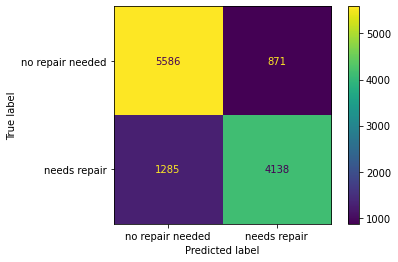

In [40]:
plot_confusion_matrix(model_rf, X_val, y_val, # <-- Use validation data
                      values_format='.0f',
                      display_labels=['no repair needed', 'needs repair']);

Precision and Recall

In [42]:
# RECALL
# Of those pumps that actually needed repair,
# what proportion did you correctly predict as needing repair?
print('Recall:', 4138 / (4138 + 1285))

Recall: 0.7630462843444588


In [43]:
# PRECISION
# Of all the pumps that you predicted as needing repair,
# what proportion actually needed repair?
print('Precision:', 4138 / (4138 + 871))

Precision: 0.826112996606109


Classification Report

In [44]:
print(classification_report(y_val, model_rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      6457
           1       0.83      0.76      0.79      5423

    accuracy                           0.82     11880
   macro avg       0.82      0.81      0.82     11880
weighted avg       0.82      0.82      0.82     11880



# Case Study

Let's say that is costs the Tanzanian government $100 to inspect a water pump, and there is only funding for 2000 pump inspections. 

In [65]:
n_inspections = 2000

Scenario 1: Choose pumps randomly

In [46]:
y_val.value_counts(normalize=True)

0    0.543519
1    0.456481
Name: needs_repair, dtype: float64

In [68]:
repair_prob = 0.456481

print('Inspections conducted:', n_inspections)
print('Pumps repaired:', round(n_inspections * repair_prob))
print('Funds wasted:', n_inspections * (1-repair_prob) * 100)

Inspections conducted: 2000
Pumps repaired: 913
Funds wasted: 108703.8


Scenario 2: Using our model "out of the box"

In [69]:
data = {'y_val': y_val,
       'y_pred': model_rf.predict(X_val)}

results = pd.DataFrame(data)

mask = results['y_pred'] == 1
sample = results[mask].sample(n_inspections)

print('Inspections conducted:', n_inspections)
print('Pumps repaired:', sample['y_val'].sum())
print('Funds wasted:', (n_inspections - sample.y_val.sum()) * 100)

#print(f'If we use our model to select {n_inspections} pumps, we expect to repair {sample['y_val'].sum()} pumps.')

Inspections conducted: 2000
Pumps repaired: 1660
Funds wasted: 34000


Scenario 3

We empasize **precision** in our model, and only select pumps that our model is very certain (`>0.9`) need repair.

In [70]:
data = {'y_val': y_val,
       'y_pred_proba': model_rf.predict_proba(X_val)[:, -1]}
results = pd.DataFrame(data)

threshold = 0.9

mask = results['y_pred_proba'] > threshold

sample = results[mask].sample(n_inspections)

print('inspections', n_inspections)
print('repairs', sample['y_val'].sum())
print('waste', (n_inspections - sample.y_val.sum()) * 100)

inspections 2000
repairs 1931
waste 6900
